In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam 
import warnings
warnings.filterwarnings('ignore')

2021-11-02 02:10:39.896053: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [19]:
ls ../dataset

train/  validation/


In [15]:
pwd

'/home/george/Documents/git/image_classification_with_openmv_camera/notebook'

In [20]:
path_to_dataset = '/home/george/Documents/git/image_classification_with_openmv_camera/dataset/'
PATH = os.path.join(os.path.dirname(path_to_dataset))
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 782 files belonging to 2 classes.


2021-11-02 02:10:46.304668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-02 02:10:46.353978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 02:10:46.354553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-11-02 02:10:46.354595: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-02 02:10:46.360105: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-02 02:10:46.360167: I tensorflow/stream_executor/pl

In [21]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 220 files belonging to 2 classes.


In [20]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

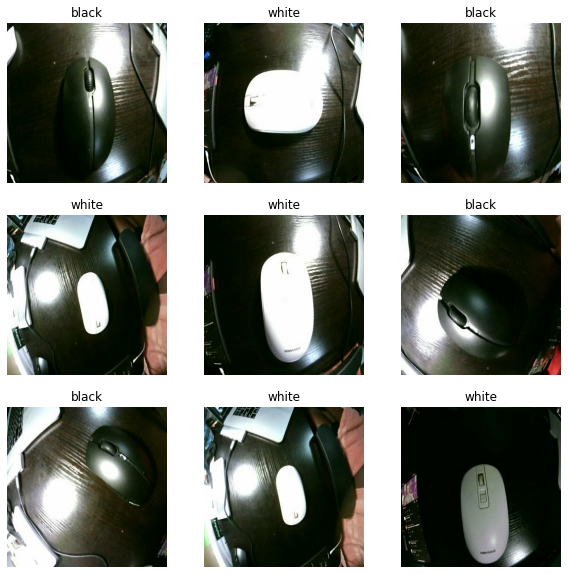

In [23]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [25]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 1


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

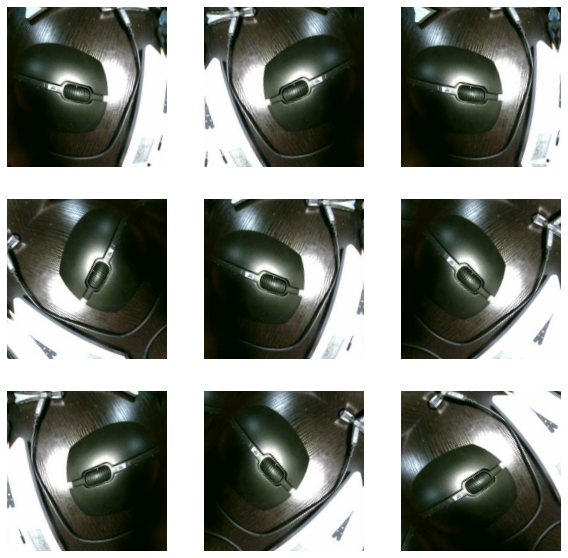

In [28]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [30]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [31]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 22s 2us/step


In [32]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2021-11-02 02:12:08.723837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-11-02 02:12:16.430014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2021-11-02 02:12:26.063041: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-02 02:12:26.063132: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-11-02 02:12:26.064258: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-02 02:12:26.064447: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-11-02 02:12:26.619314: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

(32, 5, 5, 1280)


In [33]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [35]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

In [36]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [39]:
len(model.trainable_variables)

158

In [40]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 3s 144ms/step - loss: 0.9845 - accuracy: 0.4681


In [41]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
25/25 [==============================] - 15s 297ms/step - loss: 0.2891 - accuracy: 0.8926 - val_loss: 0.0895 - val_accuracy: 0.9574
Epoch 2/10
25/25 [==============================] - 6s 241ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0218 - val_accuracy: 0.9894
Epoch 3/10
25/25 [==============================] - 6s 240ms/step - loss: 2.3647e-04 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9734
Epoch 4/10
25/25 [==============================] - 6s 243ms/step - loss: 1.0512e-04 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9947
Epoch 5/10
25/25 [==============================] - 6s 244ms/step - loss: 4.6737e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 6s 243ms/step - loss: 3.4025e-05 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 6s 259ms/step - loss: 3.2781e-05 - accuracy: 1.0000 - val_loss: 0.0068 - val_ac

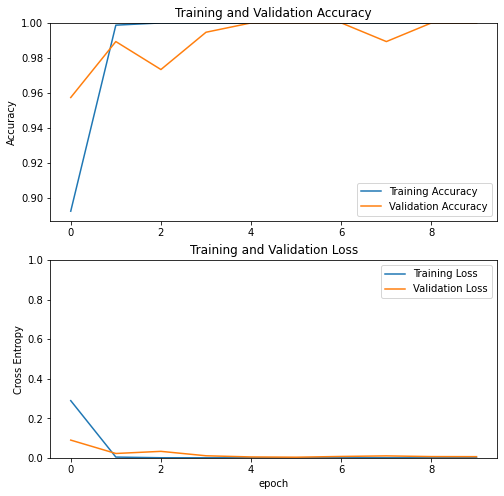

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [47]:
len(model.trainable_variables)

56

In [48]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
25/25 [==============================] - 6s 119ms/step - loss: 1.2203e-05 - accuracy: 1.0000 - val_loss: 0.0126 - val_accuracy: 0.9840
Epoch 11/20
25/25 [==============================] - 2s 94ms/step - loss: 1.1157e-06 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 12/20
25/25 [==============================] - 2s 95ms/step - loss: 4.3946e-07 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9894
Epoch 13/20
25/25 [==============================] - 2s 93ms/step - loss: 2.2344e-07 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 14/20
25/25 [==============================] - 2s 94ms/step - loss: 1.3227e-07 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 15/20
25/25 [==============================] - 2s 94ms/step - loss: 9.0608e-08 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9894
Epoch 16/20
25/25 [==============================] - 2s 94ms/step - loss: 5.8769e-08 - accuracy: 1.0000 - val_loss: 0.0089 

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

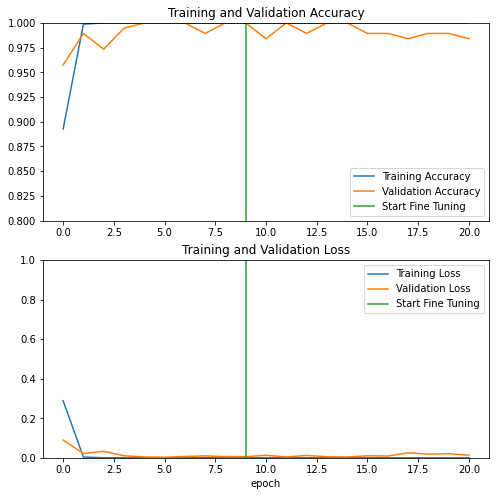

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 105ms/step - loss: 1.1611e-05 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0]
Labels:
 [1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0]


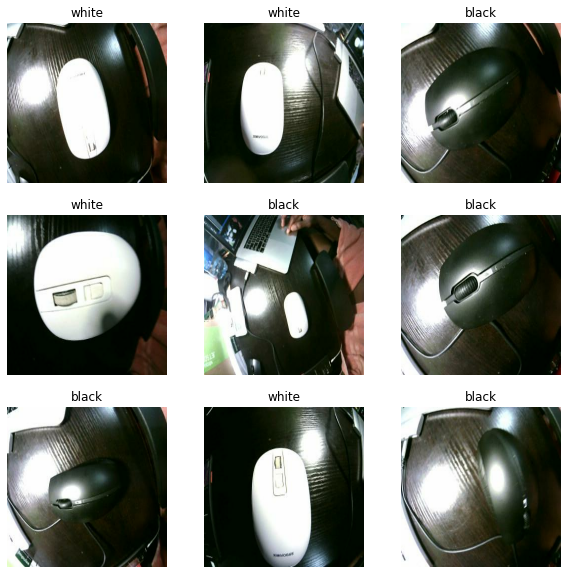

In [52]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [36]:
model

In [53]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 160, 160, 3)
        yield [data.astype(np.float32)]

In [43]:
model.save('mouse_model.h5')

In [44]:
#converter = tf.lite.TFLiteConverter.from_saved_model(model)
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('mouse_model.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [45]:
ls

mouse_model.h5  train.ipynb


In [46]:
open("mouse.tflite", "wb").write(tflite_quant_model)

2852704

In [49]:
ls

mouse.tflite    mouse_model.h5  train.ipynb


In [50]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(160,160,3)),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.sigmoid)
])

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1228816   
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 1,228,988
Trainable params: 1,228,988
Non-trainable params: 0
_________________________________________________________________


In [62]:
opt = Adam(lr=0.001)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1228816   
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 1,228,988
Trainable params: 1,228,988
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
25/25 [==============================] - 1s 44ms/step - loss: 0.5000 - val_loss: 0.5032
Epoch 2/10
25/25 [==============================] - 1s 43ms/step - loss: 0.5000 - val_loss: 0.5032
Epoch 3/10
25/25 [==============================] - 1s 43ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 4/10
25/25 [==============================] - 1s 45ms/step - loss: 0.5000 - val_loss: 0.5096
Epoch 5/10
25/25 [==============================] - 1s 43ms/step - loss: 0.5000 - val_loss: 0.5096
Epoch 6/10
25/25 [==============================] - 1s 45ms/step - loss: 0.5000 - val_loss: 0.5032
Epoch 7/10
25/25 [==============================] - 1s 43ms/step - loss: 0.5000 - val_loss: 0.5128
Epoch 8/10
25/25 [==============================] - 1s 44ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 9/10
25/25 [==============================] - 1s 44ms/step - loss: 0.5000 - val_loss: 0.4936
Epoch 10/10
25/25 [==============================] - 1s 43ms/step - loss: 0.5000 - val_loss: 0.4904


In [69]:
model.save('mouse_model_1.h5')

In [72]:
#converter = tf.lite.TFLiteConverter.from_saved_model(model)
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('mouse_model_1.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

In [71]:
ls

mouse.tflite      mouse_model.h5    mouse_model_1.h5  train.ipynb


In [18]:
# from pathlib import Path
# import imghdr

# data_dir = "/home/george/Documents/git/image_classification_with_openmv_camera/dataset/train/white"
# image_extensions = [".png", ".jpg"]  # add there all your images file extensions

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_dir).rglob("*"):
#     #print(filepath)
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")